
# 2D DOSY NMR Processing and Display


a simplified environment for processing DOSY experiments from Bruker NMR datasets.
The analysis is performed using the PALMA algorithm.

## Principle
The PALMA algorithm performs the Inverse Laplace Transform of each columns of the 2D DOSY experiment.
This inversion is performed by optimizing a target function which maximizes the Entropy of the spectrum, and minimizes its $\ell_1$ norm.

More details are found in the original publication [DOI: 10.1039/c6an01902a](http://doi.org/10.1039/c6an01902a)
or the [WEB server page](http://palma.labo.igbmc.fr/about.html) on which you will also find [advises](http://palma.labo.igbmc.fr/about.html) to obtain the best possible experiments. 

When using this program, please cite the following reference:

A.Cherni, É.Chouzenoux, and M.-A.Delsuc. (2017) "PALMA, an improved algorithm for DOSY signal processing".
*Analyst*, **142**(5), p772-779 


## Usage
Run each python cell in sequence by using the ⇥Run button above (or typing *shift* Enter).

Cells are meant to be used in order, taking you to the complete analysis, but you can go back at any time.

The SPIKE code used for processing is visible in the cells, and can be used as a minimal tutorial.


## Initialization
the following cell should be run only once, at the beginning of the processing

## STARTING Environment...


          SPIKE
    Version     : 0.99.32
    Date        : 08-02-2023
    Revision Id : 586

loading plugins... ( use spike.plugins.report() for a short description of each plugins )
*** zoom3D not loaded ***
generic plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 
user plugins loaded:
msapmin, 
*** load_dump not loaded ***
NMR plugins loaded:
Bruker_NMR_FT,  Bucketing,  Integrate,  PALMA,  apmin, 
MS plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 

Interactive module version, 1.3.0


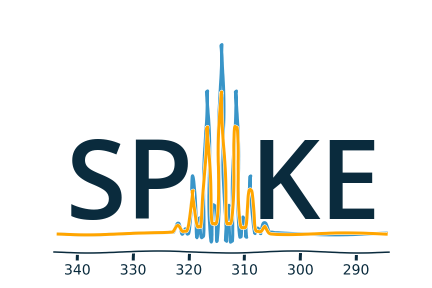

Run date: 2023-03-23T14:20:01.325345


## ...program is Ready

In [1]:
# load all python and interactive tools - has to be run only once (but it does not hurt to rerun...)
from IPython.display import display, HTML, Markdown, Image
display(Markdown('## STARTING Environment...'))
import platform
import ctypes
import os.path as op
from datetime import datetime
import matplotlib as mpl
%matplotlib widget
import spike
from spike.File.BrukerNMR import Import_1D
from spike.Interactive import INTER as I
from spike.Interactive import INTER_2D as I2D
from spike.Interactive.ipyfilechooser import FileChooser
from spike.plugins.NMR.PALMA import Import_DOSY
I.initialize()
print('Run date:', datetime.now().isoformat() )
display(Markdown('## ...program is Ready'))
from importlib import reload  # this line is debugging help

# this forces MKL -if there- to use only one thread (usually faster ! and probably required if you intend using multiprocessing)
dllnames = dict(Linux='libmkl_rt.so', Darwin='libmkl_rt.dylib', Windows='libmkl_rt.dll')
dllname = dllnames[platform.system()]
try:
    mkl_rt = ctypes.CDLL(dllname)
    mkl_rt.MKL_Set_Num_Threads(1)
except:
    print ("No MKL")

# configurable items - you may change them to fit you preferences
verbose = 1                              # chose from 0 (terse) to 3 more verbose - not fully implemented !
mpl.rcParams['figure.figsize'] = (8,4)   # (X,Y) default figure size
I.Activate_Wheel = True                  # True/False    scale with wheel control in the graphic cells 
I.reverse_scroll = False                 # inverse the direction of the mouse wheel, whether it is `True` (TrackPad) or `False` (Mouse)
I.ParamList = ['SOLVENT', 'PULPROG', 'SFO1', 'NS', 'TE', 'TD', 'D1','P1','P30','D20']    # the list of important parameters to display

### Choose the file
The `FileChooser()` tool creates a dialog box which allows to choose a file on your disk

- use the `Select` button
- modify the ( *optional* ) `path` argument, to start the exploration on a given location
- choose the `ser  file of your DOSY experiment
    - *note, the* `difflist` *file should be present*
- After the selection, the selected filename is found in `FC.selected`

In [2]:
FC = FileChooser(path='/DATA',filename='ser')
display(FC)

FileChooser(path='/DATA', filename='ser', show_hidden='False')

### Import dataset

This is simply done with the `Import_DOSY()` tool, which returns a `SPIKE` object.

We store the dataset into a variable, typing the variable name shows a summary of the dataset. 

Reading file  /DATA/SM_ARTE_v3/SM_ARTE3_161123/30/ser
DOSY performed on 1H
bpp_ste_2echoes
0.002 0.13789749999999998 0.00025 bpp_ste_2echoes 1H


Nouvelle dosy - compensee pour la convection
computed scale: 1.63


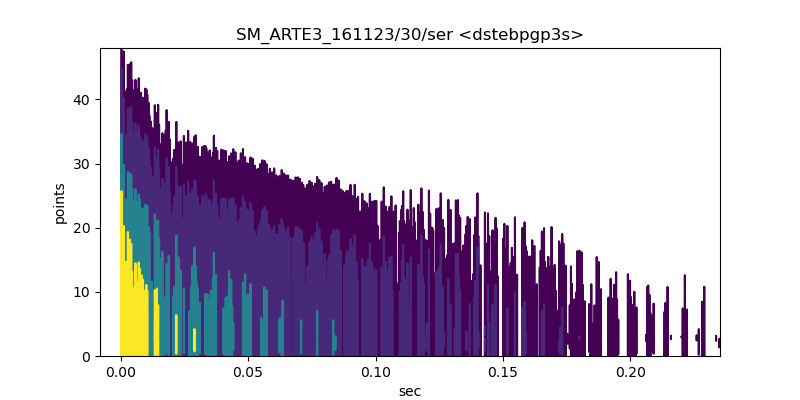

In [3]:
if not op.exists(op.join(FC.selected_path,'difflist')):
    I.jsalert('No difflist file present - is this a DOSY experiment ?')
print('Reading file ',FC.selected)
d2 = Import_DOSY(FC.selected)
d2.axis1.dmin = 10        # diffusion axis limits, values are in µm²/cm
d2.axis1.dmax = 10000     # only indicative à this level
d2.filename = FC.selected
d2.pulprog = d2.params['acqu']['$PULPROG']
display(I.summary(d2, output='HTML'))          # but summary is nicer and more informative
display(HTML(f"$q$ values from {d2.axis1.qvalues[0]} to {d2.axis1.qvalues[-1]} in {d2.size1} steps"))
# I.popup_param_table(d1)                      # this command pops up a window with the complete parameter table
print (d2.params['acqu']['title'])
d2.axis2.currentunit = 'sec'
d2.axis1.currentunit = 'points'
d2.display(title="%s/ser %s"%(FC.nmrname,d2.pulprog), scale='auto');

In the current set-up, the figure can be explored *(zoom, shift, resize, etc)* with the jupyter tools displayed  below the dataset.
The figure can also be saved as a `png` graphic file.

At anytime, the figure can be frozen by clicking on the blue button on the upper right corner, just rerun the cell to make it interactive again.

## Data Preparation
We are going to use a basic processing set-up, check the documentation for advanced processing

### Fourier Transform

computed scale: 18.96


2D data-set
Axis F1 :Laplace axis of 50 points,  from 10.000000 to 10000.000000  using a scaling factor of 247890.986993
Axis F2: NMR axis at 700.163291 MHz, 4096 complex pairs,  from -1.338538 ppm (-937.194868 Hz) to 10.683670 ppm  (7480.313549 Hz)
data-set is complex in F2

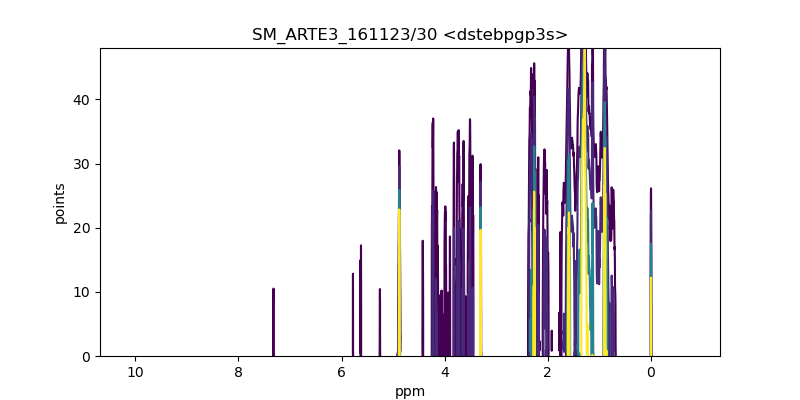

In [4]:
D2 = d2.copy() # copy the imported data-set to another object for processing
# bk_ftF2 and bk_ftF1 (define in the Bruker plugin) find which FT to apply depending on FnMODE
D2.apod_sin(maxi=0.1,axis='F2').zf(1,2).bk_ftF2().bk_pk()  # chaining  apodisation - zerofill - FT
D2.axis2.currentunit = 'ppm'
D2.display(scale="auto", autoscalethresh=6.0, title="%s %s"%(FC.nmrname,d2.pulprog))  # chain  set to ppm unit - and display

### Optimize phase
If required, rephase first rows, and the correction will be applied to the whole dataset.

Phaser1D(children=(VBox(children=(HBox(children=(Button(button_style='warning', description='Exit', style=Butt…

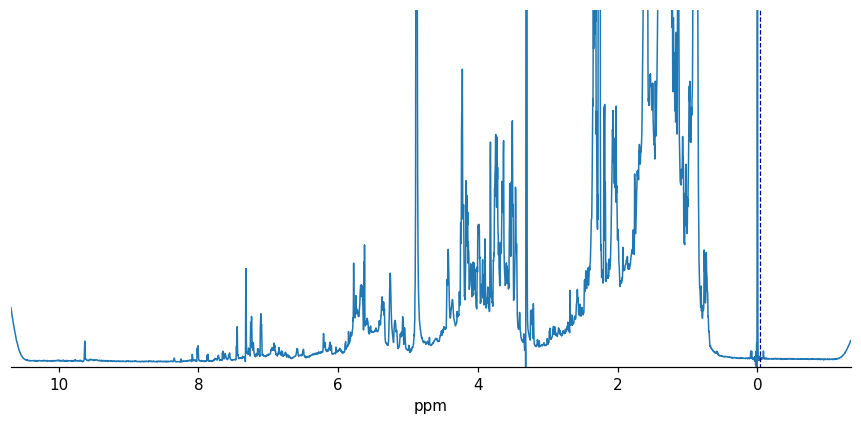

Applied: data.phase(-2.4,  29.0)
computed scale: 27.26


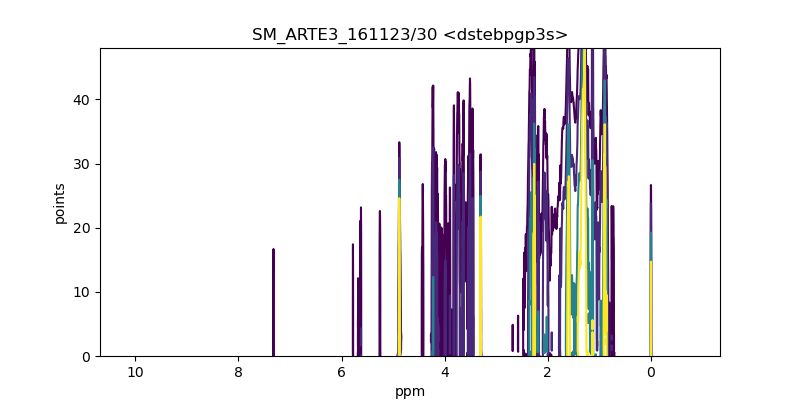

In [5]:
R1 = D2.row(0) # copy the first line to another object for processing
for i in range(4):
    R1 += D2.row(i+1)
Ph = I.Phaser1D(R1)  # phase it
def loc(b):    # patch the on_done action o the phaser to propagate to DOSY
#    Ph.on_Apply(b)
    lp0, lp1 = Ph.ppivot() # get centered values
    if lp0 != 0 or lp1 != 0:
        D2.phase(lp0, lp1, axis=2)
        D2.display(scale="auto", autoscalethresh=6.0, title="%s %s"%(FC.nmrname,d2.pulprog))
Ph.done.on_click(loc)
display(Ph)

### baseline correction  -  if needed
A flat baseline centered on 0 is a requisite for a correct analysis.
The following tool allows to point baseline positions on a extracted 1D, see the effect of the correction, and apply it to the whole 2D experiment.

- use `add` and `rem` buttons to place points at the location of the selector.
- the `auto` button populates with a first set of 8 positions

In [6]:
Dcopy  = D2.copy()   # keep an uncorrected copy, to rerun if problems

baseline1D(children=(VBox(children=(HBox(children=(Label(value='Baseline points'), IntText(value=8, layout=Lay…

Applied correction:
data.bcorr(method='linear', nsmooth=14, xpunits='current',\
           xpoints=[-0.456, 8.99]))



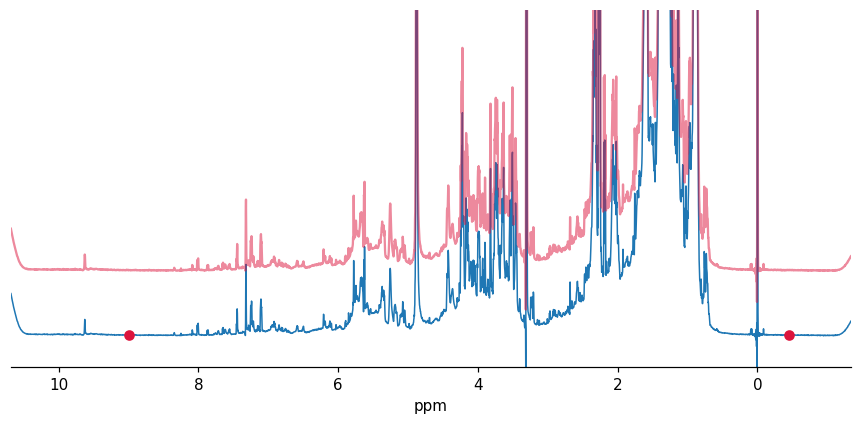

In [7]:
D2 = Dcopy.copy().real()
R1 = D2.row(0) # copy the imported data-set to another object for processing
for i in range(4):
    R1 += D2.row(i+1)
D2.projF2 = R1
b = I.baseline1D(R1)
def bslloc(e):
    for i in range(D2.size1):
        r=D2.row(i)
        r.bcorr(method='spline', xpoints=b.bsl_points, nsmooth=b.smooth.value, xpunits='current',)
        D2.set_row(i,r)
b.done.on_click(bslloc)
b

### Verify your data

In [8]:
reload(I2D)
S = I2D.Show2D(D2)
S.negview.value = True
S

/home/mad/Documents/spike/spike/NPKData.py:1623: UserWarning: No contour levels were found within the data range.
  self.disp_artist = fig.contour(axis[1][z2lo:z2up:step2],


Show2D(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Positive', layout=Layout(widt…

## PALMA processing
First set you parameters

Processing time is proportional to $N$ `x nbiter x finalsize`

where $N$ is the number of processed columns (chosen with `miniSNR`)

In [17]:
# Diffusion axis
finalsize = 256  # The final of the DOSY on the diffusion axis
Dmin = 30       # the minimum diffusion coefficient (in µm2/sec) typical is 1-100
Dmax = 10000     # the maximum diffusion coefficient (in µm2/sec) typical is 5000-50000

# Processing
nbiter=10000      # number of iterations - the more the better (usually)
lamda=0.01        # weight between "pure" MaxEnt (1.0) and "pure" l1 (0.0), 0.01 to 0.1 are "good values"

# Optionnal parameters
miniSNR = 8          # minimum SNR in column to do processing - 32 is optimal - do not go below 8
# uncertainty=1.2  # if >1 allows more room for algo when data quality is poor
# precision=1e-08  # stopping criterium

# MultiProcessing
# the processing can be lengthy,  so use can use parralelize the program
# if you do not want to use the mp capability, set NProc to 1
import multiprocessing as mp
NProc = 6          # here for 2 cores - adapt to your own requirements
if NProc > 1:
    mppool = mp.Pool(processes=NProc)
else:
    mppool = None

/home/mad/Documents/spike/spike/plugins/NMR/PALMA.py:87: RuntimeWarning: invalid value encountered in log
  s = x*(1 - np.log(x)/(1+x)) + A/(1+x-limit)**0.75
/home/mad/Documents/spike/spike/plugins/NMR/PALMA.py:87: RuntimeWarning: invalid value encountered in power
  s = x*(1 - np.log(x)/(1+x)) + A/(1+x-limit)**0.75
/home/mad/Documents/spike/spike/plugins/NMR/PALMA.py:87: RuntimeWarning: invalid value encountered in log
  s = x*(1 - np.log(x)/(1+x)) + A/(1+x-limit)**0.75
/home/mad/Documents/spike/spike/plugins/NMR/PALMA.py:87: RuntimeWarning: invalid value encountered in power
  s = x*(1 - np.log(x)/(1+x)) + A/(1+x-limit)**0.75
/home/mad/Documents/spike/spike/plugins/NMR/PALMA.py:87: RuntimeWarning: invalid value encountered in log
  s = x*(1 - np.log(x)/(1+x)) + A/(1+x-limit)**0.75
/home/mad/Documents/spike/spike/plugins/NMR/PALMA.py:87: RuntimeWarning: invalid value encountered in power
  s = x*(1 - np.log(x)/(1+x)) + A/(1+x-limit)**0.75
/home/mad/Documents/spike/spike/plugins/NMR/PA

In [18]:
D2.prepare_palma(finalsize, Dmin, Dmax)      # set-up diffusion axis

2D data-set
Axis F1 :Laplace axis of 50 points,  from 30.000000 to 10000.000000  using a scaling factor of 247890.986993
Axis F2: NMR axis at 700.163291 MHz, 4096 real points, from -1.338538 ppm (-937.194868 Hz) to 10.683670 ppm  (7480.313549 Hz)
data-set is real

In [19]:
DD2 = D2.do_palma(nbiter=nbiter, miniSNR=miniSNR, lamda=lamda, mppool=mppool)  # launch computation

PALMA: 100% [---------------------------------------------------------------------------------------------]Time: 0:14:26


In [20]:
if mppool: mppool.close()  # clean-up

### And display result
Diffusion coefficients are along the vertical axis. Values are in $\mu m^2 / sec$ which is $10^{-12} m^2 / sec$.
Typical diffusion of small molecules in a solvent are between 100 and 1000 $\mu m^2 / sec$ ($10^{-10} - 10^{-9} m^2 / sec$). Expect water around $3000 \, \mu m^2 / sec$ ($3 \, 10^{-10} m^2 / sec$)


Show2D(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Positive', layout=Layout(widt…

/home/mad/Documents/spike/spike/Interactive/INTER_2D.py:217: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  self.spec_ax.clear()
/home/mad/miniconda3/envs/OW/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


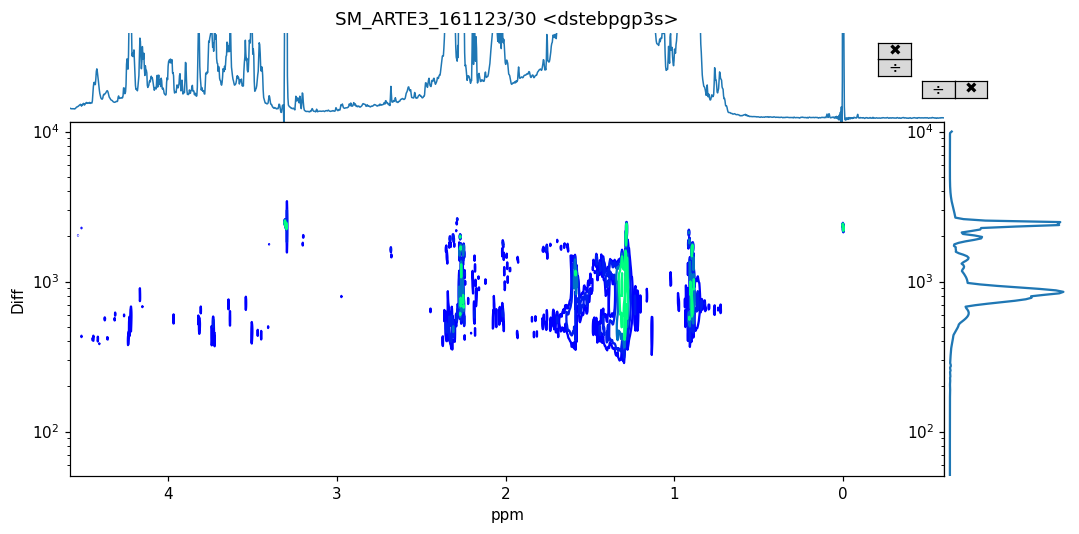

In [24]:
DD2.axis1.currentunit = 'Diff'
DD2.projF2 = D2.row(1)
DD2.projF1 = DD2.proj(axis=1,)
SDosy = I2D.Show2D(DD2, title="%s %s"%(FC.nmrname,d2.pulprog))
SDosy.scale.max = 100
SDosy

## Save the data-set
either as stand alone native SPIKE files, (there are other formats)

In [25]:
# a complete autonomous data format for DOSY is in development,
# storing the processed dataset is a solution, but requies to keep the original acquired data    
DD2.save('processed_Dosy.gs2')

writing 2D


2D data-set
Axis F1 :Laplace axis of 256 points,  from 30.000000 to 10000.000000  using a scaling factor of 247890.986993
Axis F2: NMR axis at 700.163291 MHz, 4096 real points, from -1.338538 ppm (-937.194868 Hz) to 10.683670 ppm  (7480.313549 Hz)
data-set is real

*Tools in this page is under intensive development - things are going to change rapidly.*